# Introduction To Flow-Based Generative Models

$\newcommand{\pf}[2]{\frac{\partial {#1}}{\partial {#2}}}$

In [9]:
import torch as T
from torch.autograd import Variable
from torch import nn, optim
from torch.nn.utils import weight_norm
import numpy as np
import warnings
warnings.filterwarnings("ignore")


# Introduction

One of the most fundamental questions we ask in the field of machine learning/AI is: if we are given a "sufficient" amount of data can we disentangle the complicated patterns of the data and build representations that capture its most important factors and variations? This task is commonly known as representation learning and can be seen as a central goal for all machine learning models. Unfortunately, a large amount of current models rely on supervised data which often requires a large amount of labeled data. As there is clearly a much larger amount of unlabeled data available,  it would be ideal to work with unsupervised (or semi-supervised) models instead.

One approach to unsupervised learning is called generative probabilistic modeling. In generative probabilistic modeling the goal is to learn an unknown full join probability distribution $p(x)$ over all the variables $x \in R^{D}$ and is assumed to come from an i.i.d dataset $\mathcal{D}$, where $D$ is the dimension of the dataset. In general this is an extremely difficult task due for training (parameter estimation), inference, and sampling. As such a central problem in generative modeling is creating models with enough capacity while still remaining tractable. Despite these challenges, the field of probabilistic generative modeling has seen rapid advances in recent years by leveraging neural networks as function approximators. They also often use a latent dimension commonly denoted as $z$ and impose a simple prior that a neural network can then map to. This can be clearly seen in the following figure.

A few examples of common generative models are the following:

1. Deep Belief Networks (Restricted Boltzman Machines): These are probabilistic undirected models that rely on a conditional independence property in each layer between intra-layer units, thus allowing for a simple factored structure. Unfortunately they rely on MCMC sampling (or Gibbs sampling) for training and sampling and often have poor mixing between modes.  
    
2. Variational Autoencoders:  These are directed probabilistic models that maximize a variational lowerbound on the log-likelihood combined with a simple latent dimension prior (isotropic Gaussian) and employ the reparameterization trick to learn the parameters of the distribution. Unfortunately they can be difficult to optimize due to over- regularization.
    
3. Autoregressive models: Avoid the use of latent variables and instead it into a product of conditions according to a fixed ordering over all the dimensions of the data. A few noteable examples are [WaveNet](https://deepmind.com/blog/wavenet-generative-model-raw-audio/) and [PixelCNN/PixelRNN](https://github.com/openai/pixel-cnn). Unfortunately these models are non-paralizeable and there run-time scales poorly with dimension.

4. GAN: A simple neural network pair consisting of a generator which generates samples and a discriminator that tries to distinguish between the samples and real data. Avoids the entire concept of maximum likelihood all-together thus allowing it to generate highly realistic data (images). Unfortunately it has no encoder, so it is difficult to represent in a latent space. They are also extrememely difficult to optimize and create any reliable metrics for comparisons between models. Probably the most notable application of GANs is image-to-image translation as seen by the popular [pix2pix/CycleGAN](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix).


For this notebook we consider a different latent variable model that utilizes a "normalizing flow" in order to learn the generating distribution. The current state of the art model for this type of model is OpenAI's [GLOW](https://blog.openai.com/glow/).


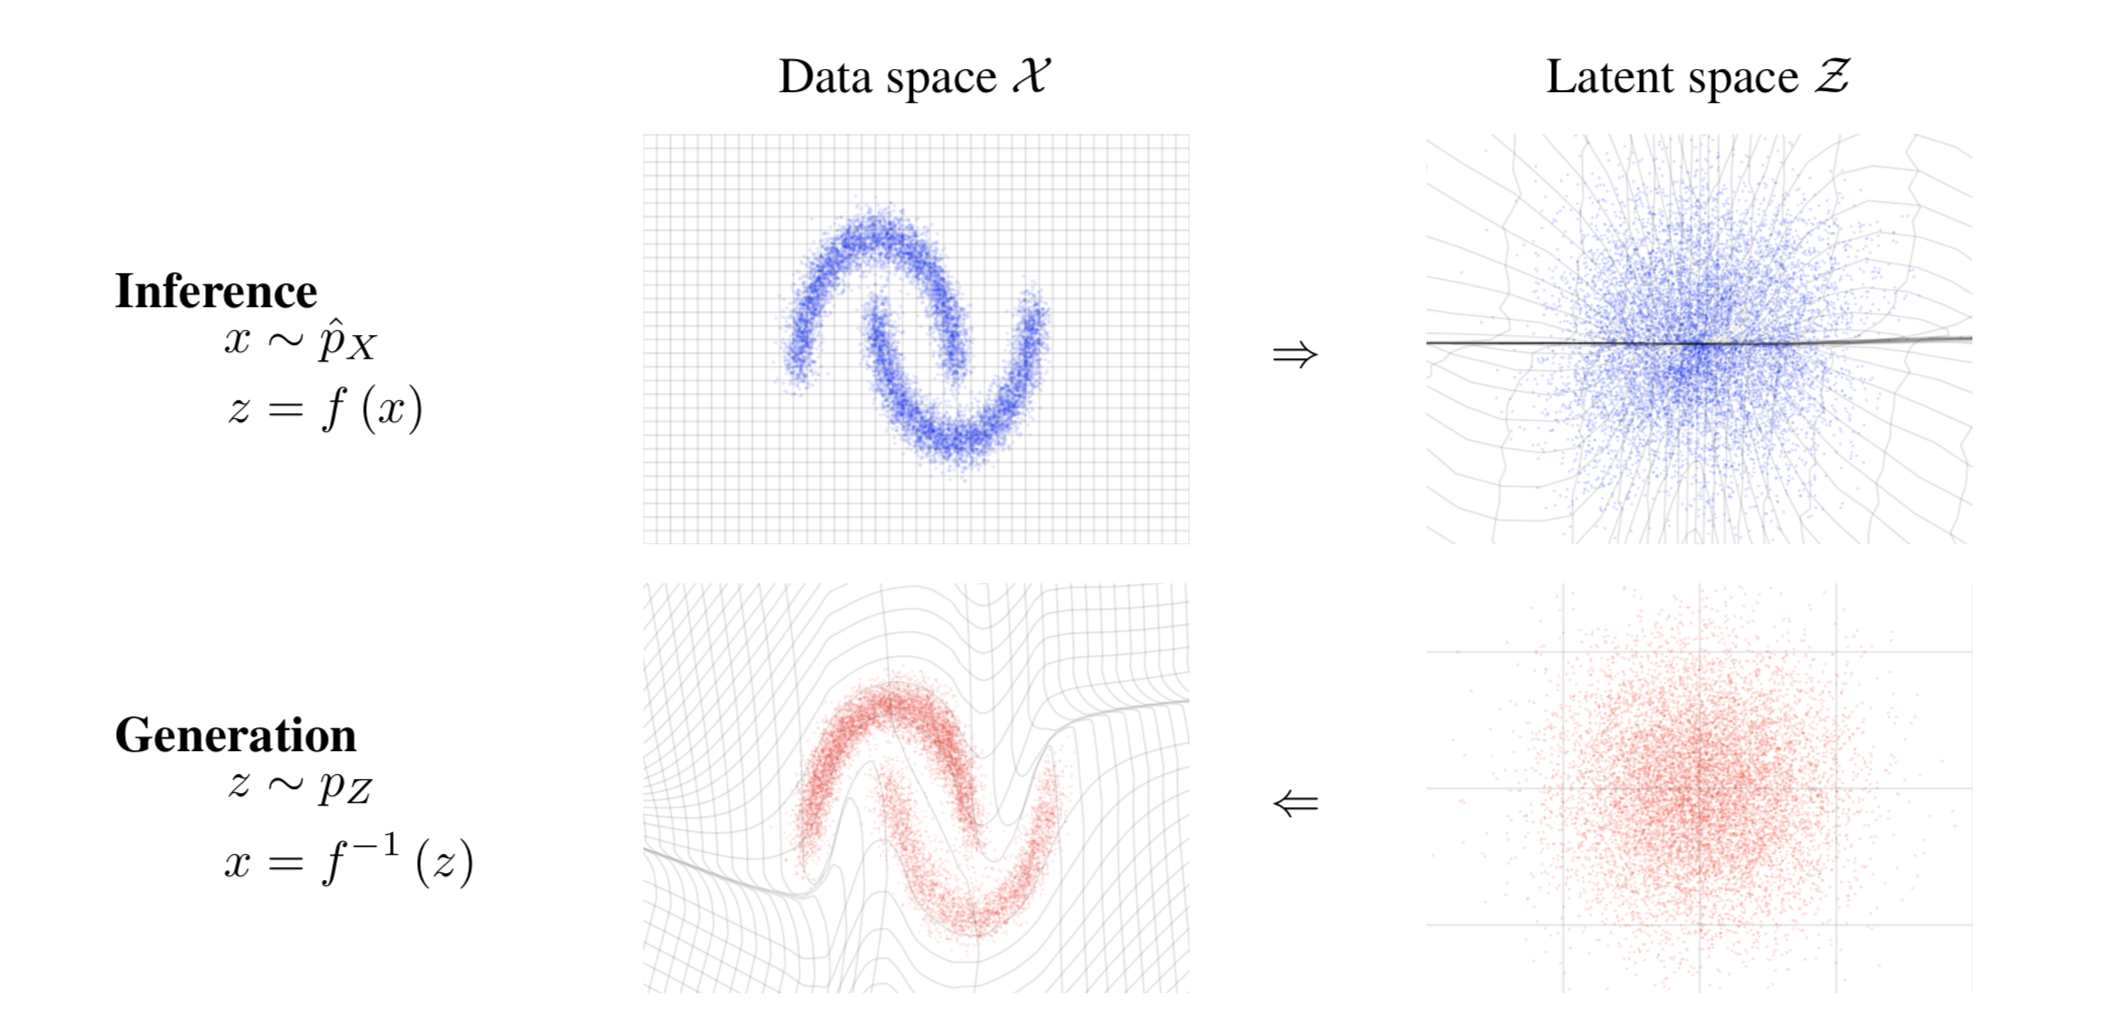

In [1]:
from IPython.display import Image
Image(filename='generative_model_overview.png')

# Formulation

Suppose we have a $D$ dimensional random vector $x \in R^D $ that has some unknown distribution $x \sim \hat{p}(x)$. We seek to find a model $\hat{p}_\theta(x)$ with optimal parameters $\hat{\theta}$ given by the maximum likelihood estimation:

\begin{aligned}
\hat{\theta} &= \text{argmax } \mathcal{L}(\mathcal{D}) \\
            &= \text{argmax }\frac{1}{N} \sum_i^N \log{p_\theta} \left( x^{(i)}\right)\\
             &= \text{argmin } \frac{1}{N} \sum_i^N -\log p_\theta \left( x^{(i)}\right)
\end{aligned}

where $\mathcal{L}$ is the likelihood function and $N$ is the size of our batch.

We can then define a latent random vector $z \sim \mathcal{N}(z,0,I)$ that maps to $x$ by an invertible function (also known as bijective) $g$ such that $z = f_\theta(x) = g_\theta^{-1}(x)$. Since these functions are parameterized by our model we can use neural networks to approximate them. Then we can simply apply the change of variables formula for distributions given as:

\begin{aligned}
p_\theta(x) &= p_\theta(z) \left|{ \det\left(\frac{\partial g(z)}{\partial z^T}\right) }\right|^{-1}  \\
            &= p_\theta(z) \left|{ \det\left(\frac{\partial f(x)}{\partial x^T}\right) }\right| 
\end{aligned}

$$ 
\log p_\theta(x) = \log p_\theta(z) + \log \left( \left|{ \det\left(\frac{\partial f(x)}{\partial x^T}\right) }\right|\right) 
$$

Unfortunately computing the determinant of the Jacobian $\frac{\partial f(x)}{\partial z^T}$ is intractable for any high capacity function. So we will instead compose $f$ as a composition of invertible functions given as $f =  f_1 \circ f_i \circ \cdots \circ f_K $, where the relationship between $x$ and $z$ is:

$$ x = y_0 \overset{f_1}{\longleftrightarrow} y_1 \overset{f_i}{\longleftrightarrow} y_i \cdots  \overset{f_K}{\longleftrightarrow} y_K  = z $$

This composition of functions is commonly referred to as a flow. The trick is now to define a simple bijection $f_i$ in such a way that it is invertible and has an easily computable determinant for each Jacobian $\frac{\partial y_i}{\partial y_{i-1}^T}$. The way we accomplish this task is to partition each input $x \in R^{NxD} $ into  a $x_{1:d} \in R^{N \times d}$ dimensional and $x_{d+1:D} \in R^{N \times (D-d)}$ dimensional tensor for some $d < D$. We can now define an affine coupling layer as:

\begin{align}
y_{1:d} &= x_{1:d} \\
y_{d+1:D} &= x_{d+1:D} \odot \exp\left(s(x_{1:d})\right) + t(x_{1:d}
\end{align}

and its inverse as:
\begin{align}
x_{1:d} &= y_{1:d} \\
x_{d+1:D} &= (y_{d+1:D}  - t(y_{1:d}))\odot \exp\left(-s(y_{1:d})\right) 
\end{align}


where $s$ and $t$ are functions that map from $R^{D} \rightarrow R^{D-d}$ and $\odot$ is the Hadamard or element-wise product. The key thing to note about this affine coupling layer is that provided we pick the same dimensions to split on in the inference and sampling passes the first partition $(x,y)_{1:d}$ will be the same and only the second partition  $(x,y)_{d+1:D}$ will be updated. This means we need to create some pattern to allow for the function compositions to update all $D$ input components.


The Jacobian of this transformation can be written as:

$$ \pf{y}{x^T} = \left[ \begin{array}{*{20}{c}}
{I_d}&{\mathbf{0}}\\
{\pf{y_{d+1:D}}{x^T_{1:d}}}&{\text{diag}\left[\exp \left(s(x_{1:d}) \right) \right]}
\end{array} \right] $$

As we know from linear algebra any triangular matrix has a determinant that is equal to the product of its diagonal, hence the determinant can be computed as 

\begin{align}
\det\left(\pf{y}{x^T}\right) &= \prod_j \exp\left(s(x_{1:d})_j\right)\\
&= \exp \left[ \log\left( \prod_j \exp\left(s(x_{1:d})_j\right)\right) \right] \\
&= \exp\left[\sum_j \log \left(\exp\left(s(x_{1:d})_j\right)\right)\right] \\
&= \exp \left[\sum_j s(x_{1:d})_j\right]
\end{align}


We now have all the results we need to effectively compute the negative log-likelihood. Let us consider the Gaussian prior first. 

$$ p_\theta(z) = \mathcal{N}(z,0,I) = \frac{ \exp\left( -\frac{1}{2} z^T z \right)}{\sqrt{2 \pi}^D} $$

$$ \log p_\theta(z) = \frac{1}{2}\left(z^T z - \frac{1}{2} D \log(2 \pi) \right) $$


In order to calculate the $\log\lvert\det(\cdot)\rvert$ term note that by the chain rule

$$ \pf{z}{x^T} = \pf{f_1 \circ f_i \circ \cdots \circ f_K }{x^T} = \prod_i \pf{y_{i}}{y_{i-1}^T} $$

Therefore, since $\det{AB} = \det{A}\det{B}$ we can write:

\begin{align}
\log  \left|  \det\left( \pf{z}{x^T}\right) \right| &= \log  \left|  \det\left(\prod_i \pf{y_{i}}{y_{i-1}^T} \right) \right| \\
&= \sum_{i=1}^K \log \left|\det\left(\pf{y_i}{y_{i-1}} \right) \right|\\
&= \sum_{i=1}^K \text{sum}\left(\log\left(\left| \text{diag} \left(\pf{y_i}{y_{i-1}} \right)\right|\right) \right)
\end{align}


# Implementation



In [10]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [36]:
N = 2000
x,L = make_moons(n_samples=N,noise=.05)

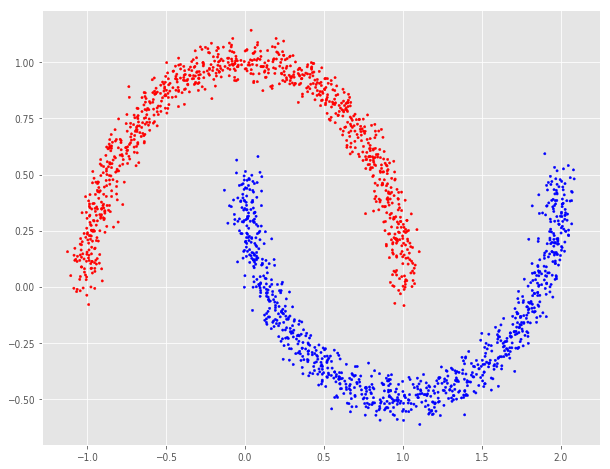

In [37]:
plt.figure(figsize=(10,8))
C = list(map(lambda x: 'r' if x==0 else 'b',L))
plt.scatter(x[:,0],x[:,1],c=C,s=5,cmap=plt.cm.ocean)
plt.show()

In [38]:
_get_even = lambda x: x[:,0::2]
_get_odd = lambda x: x[:,1::2]
def _set_even_(x,y):
    x[:,0::2] = y
def _set_odd_(x,y): 
    x[:,1::2] = y
    
def interleave_(x,even,odd):
    '''given two tensors a,b of size (N,(d-1)) and (N,D-(d-1)) we need to '''
    _set_even_(x,even)
    _set_odd_(x,odd)
    #return(x)
    
def interleave(even,odd):
    arr = [T.cat([even[:,k].view(-1,1),odd[:,k].view(-1,1)],dim=1) for k in range(odd.shape[1])]
    if (even.shape[1]> odd.shape[1]):
        arr += [even[:,-1].reshape(-1,1)]
    return(T.cat(arr,dim=1))

In [39]:
x_ = T.rand(1000,7)
x_

tensor([[ 0.2438,  0.5277,  0.7529,  ...,  0.4879,  0.9498,  0.4712],
        [ 0.4562,  0.1621,  0.9669,  ...,  0.9633,  0.3299,  0.7334],
        [ 0.2651,  0.0319,  0.7823,  ...,  0.5004,  0.5615,  0.6109],
        ...,
        [ 0.0582,  0.5680,  0.4691,  ...,  0.1133,  0.2812,  0.5296],
        [ 0.8345,  0.2827,  0.7305,  ...,  0.4231,  0.5369,  0.5157],
        [ 0.7605,  0.6612,  0.2624,  ...,  0.1446,  0.9296,  0.9586]])

In [40]:
even_x = _get_even(x_)
odd_x = _get_odd(x_)
new_even_x = even_x*.5 + 2
new_even_x

tensor([[ 2.1219,  2.3764,  2.2439,  2.2356],
        [ 2.2281,  2.4834,  2.4816,  2.3667],
        [ 2.1326,  2.3911,  2.2502,  2.3054],
        ...,
        [ 2.0291,  2.2345,  2.0566,  2.2648],
        [ 2.4173,  2.3652,  2.2116,  2.2579],
        [ 2.3803,  2.1312,  2.0723,  2.4793]])

In [41]:
arr = interleave(new_even_x,odd_x)

In [42]:
arr

tensor([[ 2.1219,  0.5277,  2.3764,  ...,  2.2439,  0.9498,  2.2356],
        [ 2.2281,  0.1621,  2.4834,  ...,  2.4816,  0.3299,  2.3667],
        [ 2.1326,  0.0319,  2.3911,  ...,  2.2502,  0.5615,  2.3054],
        ...,
        [ 2.0291,  0.5680,  2.2345,  ...,  2.0566,  0.2812,  2.2648],
        [ 2.4173,  0.2827,  2.3652,  ...,  2.2116,  0.5369,  2.2579],
        [ 2.3803,  0.6612,  2.1312,  ...,  2.0723,  0.9296,  2.4793]])

In [43]:
interleave_(x_,new_even_x,odd_x)

In [44]:
x_

tensor([[ 2.1219,  0.5277,  2.3764,  ...,  2.2439,  0.9498,  2.2356],
        [ 2.2281,  0.1621,  2.4834,  ...,  2.4816,  0.3299,  2.3667],
        [ 2.1326,  0.0319,  2.3911,  ...,  2.2502,  0.5615,  2.3054],
        ...,
        [ 2.0291,  0.5680,  2.2345,  ...,  2.0566,  0.2812,  2.2648],
        [ 2.4173,  0.2827,  2.3652,  ...,  2.2116,  0.5369,  2.2579],
        [ 2.3803,  0.6612,  2.1312,  ...,  2.0723,  0.9296,  2.4793]])

## Model

In [45]:
import torch.nn as nn


class ModelST(nn.Module):

    """The Scale or Translation Function that maps from R^d -> R^(D-d)"""

    def __init__(self,D,d,hidden_dims):

        super(ModelST,self).__init__()
        
        d_inputs = [d,*hidden_dims] #
        d_outputs = [*hidden_dims,D-d]
        num_hidden_layers = len(d_inputs)-1
        relu = nn.ReLU()

        hidden_layers = []
        for i in range(num_hidden_layers):
            hidden_layer = weight_norm(nn.Linear(d_inputs[i],d_outputs[i]))
            hidden_layers += [hidden_layer,relu]

        linear = weight_norm(nn.Linear(d_inputs[-1],d_outputs[-1]))

        self.network = [*hidden_layers,linear]
        self.net = nn.Sequential(*self.network)
        self.init_weights()

    def init_weights(self):
        for layer in self.network:
            try:
                T.nn.init.xavier_normal_(layer.weight)
                T.nn.init.zeros_(layer.bias)
            except AttributeError:
                continue

    def forward(self,x):
        out = self.net(x)
        return(out)
    

class AffineCouplingLayer(nn.Module):
        
    
    def __init__(self,D,partition_type,hidden_dims = [100,100],):
        super(AffineCouplingLayer,self).__init__()
        
        # get the even and odd dimensions
        if D%2 == 0:
            even_d = odd_d = d = D//2
        else:
            even_d = D//2 + 1
            odd_d = D//2
        
        assert(partition_type in range(2))
        
        self.partition_type = partition_type    
        
        if self.partition_type == 1:
            # then the first is odd and second is even
            self._first =  _get_odd
            self._second = _get_even
            self.d = even_d
           
        else:
            # then the first is even and second is odd
            self._first = _get_even
            self._second = _get_odd
            self.d = odd_d

        self.s = ModelST(D,d,hidden_dims)
        self.t = ModelST(D,d,hidden_dims)
                
    
    
    def forward(self,x,calc_det = True):
        """
        Parameters:
            x : tensor of dtype=float32 and shape=(M,D)
        """
        first = self._first(x) #dim d
        second = self._second(x) #dim D-d
        new_second = second*T.exp(self.s(first))+self.t(first)
        if self.partition_type == 1:
            # then the first is odd
            out = interleave(new_second,first) 
        else:
            # then the first is even
            out = interleave(first,new_second)
            
        if calc_det:
            return(out,
                   T.exp(T.sum(self.s(first),dim=1,keepdim=True)) 
                  )
        else:
            return(out)
        
        
    def inverse(self,y):
        first = self._first(y)
        second = self._second(y)
        new_second = (second - self.t(first))*T.exp(-self.s(first))
        if self.partition_type == 1:
            # then the first is odd
            return(interleave(new_second,first))
        else:
            # then the first is even
            return(interleave(first,new_second))  
        
    
class Model(nn.Module):

    def __init__(self,D,hidden_dims = [100,100]):

        super(Model,self).__init__()
        self.hidden_dims = hidden_dims
        self.D = D
    
        # ideally we would like to extract this away for building any number of layers
        self.layer1 = AffineCouplingLayer(D,0,hidden_dims=hidden_dims)
        self.layer2 = AffineCouplingLayer(D,1,hidden_dims=hidden_dims)
        self.layer3 = AffineCouplingLayer(D,0,hidden_dims=hidden_dims)
        self.layer4 = AffineCouplingLayer(D,1,hidden_dims=hidden_dims)

    def forward(self,x,calc_det=True,debug=False):
        """ the forward inference from x to z """
        
        if debug:
            return(self.layer1(x,False))
        
        # ideally we would like to write a helper function to handle the loop/recursive calls
        y1,dy1_det = self.layer1(x)
        y2,dy2_det = self.layer2(y1)
        y3,dy3_det = self.layer3(y2)
        z,dz_det = self.layer4(y3)
        
        if calc_det:
            return(z,T.cat([dy1_det,dy2_det,dy3_det,dz_det],dim=1))
        else:
            return(z)
    
    def inverse(self,z,debug=False):
        if debug:
            return(self.layer1.inverse(z))
        
        y3 = self.layer4.inverse(z)
        y2 = self.layer3.inverse(y3)
        y1 = self.layer2.inverse(y2)
        x = self.layer1.inverse(y1)
        return(x)

In [46]:
x = x.astype(np.float32)
X = T.from_numpy(x)
D = X.shape[1]
model = Model(D)
z= model(X,False)
zinv = model.inverse(z,False)

In [47]:
T.allclose(X,zinv,1e-4)

True

## Loss Function

In [48]:
def log_gaussian_likelihood(z,D):
    return(-0.5*(T.sum(z*z,dim=1)+D*np.log(2*np.pi)))

def log_change_of_variables(dys):
    return(T.sum(T.log(T.abs(dys)),dim=1))
        
def log_likelihood(z,dys,D,alpha=1.0,
                   log_prior_fn = log_gaussian_likelihood ):
    return(T.mean(log_prior_fn(z,D) + alpha*log_change_of_variables(dys)))

In [49]:
model = Model(D)

z,dys= model(X)
loss = log_likelihood(z,dys,D)

In [50]:
model

Model(
  (layer1): AffineCouplingLayer(
    (s): ModelST(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): ReLU()
        (4): Linear(in_features=100, out_features=1, bias=True)
      )
    )
    (t): ModelST(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): ReLU()
        (4): Linear(in_features=100, out_features=1, bias=True)
      )
    )
  )
  (layer2): AffineCouplingLayer(
    (s): ModelST(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=100, bias=True)
        (3): ReLU()
        (4): Linear(in_features=100, out_features=1, bias=True)
      )
    )
    (t): ModelST(
      (net): Sequential(
       

In [51]:
T.exp(loss)

tensor(1.00000e-02 *
       7.5130)

## Training

In [52]:
model = Model(D)
#N = 1000
x,L = make_moons(n_samples=N,noise=.05)
X = T.from_numpy(x.astype(np.float32))

In [53]:
from tqdm import tqdm,tqdm_notebook
import torch.optim as optim
import time

class args:
    lr = 0.0001
    batch_size = N
    clip = 0.15

D = X.shape[1]
model = Model(D)
args.D = D
M = args.batch_size
args.M = M
optimizer  = optim.Adam(model.parameters(), lr=args.lr)
args.num_batches = X.shape[0]//args.batch_size

def train(epoch,model,args):
    model.train()
    total_loss = 0
    start_time = time.time()
    losses = []
    for i in range(args.num_batches):
        inp = X[i*args.M:(i+1)*args.M,:]
        optimizer.zero_grad()
        z,dys= model(inp)
        loss = -1*log_likelihood(z,dys,args.D)
        loss.backward()
        if args.clip > 0:
            T.nn.utils.clip_grad_norm(model.parameters(), args.clip)
        optimizer.step()
        total_loss += loss.data
#         if i % 100 == 0:
#             eval_loss = evaluate()
#             print(eval_loss)
        #print(loss.data)
    return(total_loss/args.batch_size)

In [54]:
args.epochs = 2000
#args.lr = 0.001
try:
    print("Training for %d epochs..." % args.epochs)
    print("epoch     NLL")
    all_losses = []
    best_vloss = 1e7
    
    for epoch in tqdm_notebook(range(1, args.epochs + 1)):
#         eval_loss = evaluate()
#         print(eval_loss)
        loss = train(epoch,model,args)

        if epoch%100 == 0:
            print(epoch,loss.data.numpy())
        #eval_loss = evaluate()
        #print(eval_loss)
except KeyboardInterrupt:
    """ Allows us to do post processing for our model on keyboard interrupt 
       such as saving the model """
    pass

Training for 2000 epochs...
epoch     NLL

100 0.0007369302
200 0.000509231
300 0.0004004386
400 0.0003561282
500 0.00033977153
600 0.00032544797
700 0.00031270323
800 0.00029902073
900 0.0002818223
1000 0.00026479084
1100 0.00024924305
1200 0.00023665639
1300 0.00022695644
1400 0.00021842426
1500 0.00021146332
1600 0.00020640364
1700 0.0002020724
1800 0.00019745305
1900 0.00019298536


# Latent Space Analysis

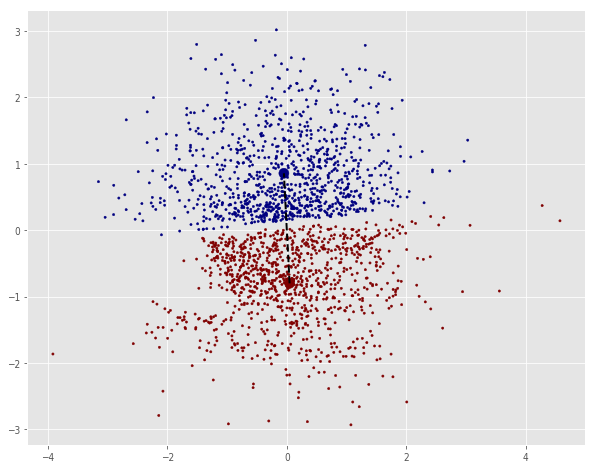

In [56]:
z,dys= model(X)
z_np = z.detach().numpy()
x = X.detach().numpy()

# get end points for latent space manipulation 
pos_idx = np.where(L == 1)[0]
neg_idx = np.where(L== 0)[0]
z_pos = T.mean(z[pos_idx],dim=0)
z_neg= T.mean(z[neg_idx],dim=0)

# Plot the latent dim and manipulation vector
plt.figure(figsize=(10,8))
from matplotlib.markers import MarkerStyle
z_means = np.vstack([z_pos.detach().numpy(),
                     z_neg.detach().numpy()])

plt.scatter(z_np[:,0],z_np[:,1],c=L,s=5,cmap='jet')
plt.plot(z_means[:,0],z_means[:,1],'--k',linewidth=2)
plt.scatter(z_means[:,0],z_means[:,1],s=100,c=[1,0],
            marker=MarkerStyle('o',fillstyle='full'),cmap='jet')
plt.show()

In [57]:
n = 100
alphas = T.linspace(0,1,n)
points = T.zeros(n,D)
for i in range(n):
    attribute_manip_vector_fn = lambda alpha: (alpha*z_pos + (1-alpha)*z_neg).view(1,-1)
    points[i,:] = model.inverse(attribute_manip_vector_fn(alphas[i]))
    
points_np = points.detach().numpy()

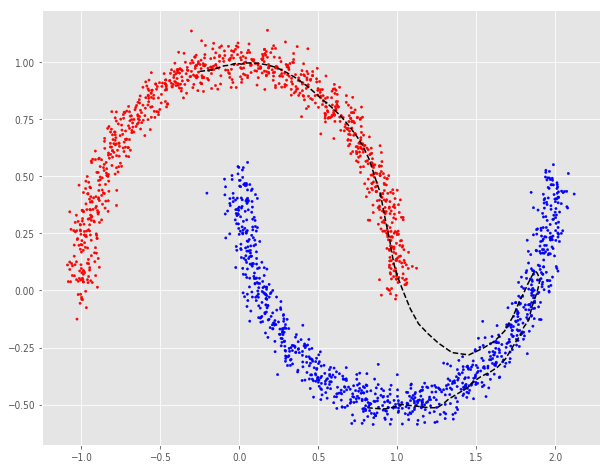

In [58]:
plt.figure(figsize=(10,8))
C = list(map(lambda x: 'r' if x==0 else 'b',L))
plt.scatter(x[:,0],x[:,1],c=C,s=5,cmap=plt.cm.ocean)
plt.plot(points_np[:,0],points_np[:,1],'k--')
plt.show()

# References

- Dinh, L., Krueger, D., and Bengio, Y. (2014). Nice: non-linear independent components estimation. arXiv preprint arXiv:1410.8516.

- Dinh, L., Sohl-Dickstein, J., and Bengio, S. (2016). Density estimation using Real NVP. arXiv preprint arXiv:1605.08803.

- Diederik P. Kingma, Prafulla Dhariwal. (2018). Glow: Generative Flow with Invertible 1×1 Convolutions